# INFEKTA: A General Agent-based Model for Transmission of Infectious Diseases: Studying the COVID-19 Propagation in Bogotá - Colombia

This report explains the methodology used for the Modeling the Transmission Dynamics of the COVID-19 in Bogotá - Colombia.

In [105]:
# Load the libraries
import numpy as np
import pandas as pd
import geopandas # For plot the bogota shapes
import sys 
import math
from io import StringIO 
import matplotlib.pylab as plt

## Population Generation

## Places Generation

Visualize the places in the Bogotá map (Using Geopandas)

In [109]:
mapLocalidades = geopandas.read_file('./Data/locashp')
mapLocalidades = mapLocalidades[mapLocalidades['LocCodigo'] != '20']

dataPlaces  = pd.read_csv('./Data/places.csv')
dataPlaces['name'] = ''
dataPlaces.columns = ['id', 'x', 'y', 'type', 'name']

dataTrasmilenio = pd.read_excel('./Data/transmilenio.xlsx')
dataTrasmilenio = dataTrasmilenio[['numero_estacion', 'X', 'Y', 'nombre_estacion' ]]
dataTrasmilenio['type'] = 'B'
dataTrasmilenio.columns = ['id', 'x', 'y', 'name', 'type']
dataTrasmilenio = dataTrasmilenio[['id', 'x', 'y', 'type', 'name']]

plotData = pd.concat([dataTrasmilenio, dataPlaces])


plotData.head()

id          x         y type             name
0  4003 -74.100288  4.702486    B         AV. Cali
1  7004 -74.142650  4.595567    B          Venecia
2  4105 -74.077401  4.681821    B       Carrera 53
3  7104 -74.077663  4.657291    B    Simón Bolívar
4  4000 -74.110506  4.709829    B  Portal de la 80

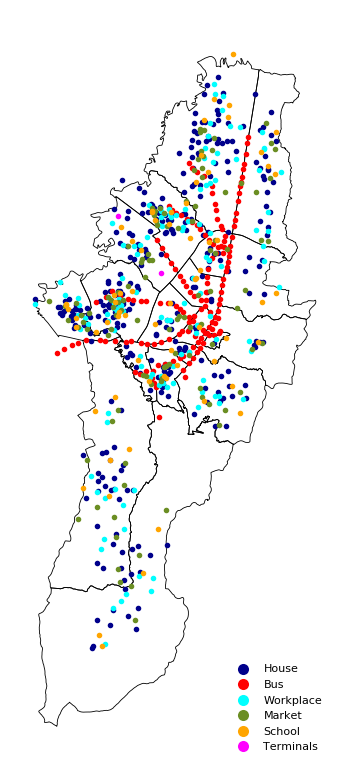

In [110]:
import matplotlib.pylab as plt
from matplotlib.lines import Line2D

myDPI = 200
fig, ax = plt.subplots(dpi=myDPI)#figsize=( 732.634438/myDPI,  837.435634/myDPI), dpi=myDPI)

mapLocalidades.plot(ax = ax, edgecolor='black', facecolor='none', lw=0.3)


pType = plotData['type'].value_counts().keys()

def changeName(x):
    if x == 'H':
        return 'House'
    elif x == 'S':
        return 'School'
    elif x == 'M':
        return 'Market'
    elif x == 'W':
        return 'Workplace'
    elif x == 'T':
        return 'Terminals'
    else:
        return 'Bus'

for i, c in zip(pType, ['darkblue', 'red', 'cyan', 'oliveDrab', 'orange', 'magenta']):
    # print(i, c)
    ax.scatter(plotData[plotData['type'] == i]['x'], plotData[plotData['type'] == i]['y'], 
               s=1, label=changeName(i), c=c)
    
legend_elements = [Line2D([0], [0], marker='o', color='w', label='House',
                          markerfacecolor='darkblue', markersize=5),
                  Line2D([0], [0], marker='o', color='w', label='Bus',
                          markerfacecolor='red', markersize=5),
                  Line2D([0], [0], marker='o', color='w', label='Workplace',
                          markerfacecolor='cyan', markersize=5),
                  Line2D([0], [0], marker='o', color='w', label='Market',
                          markerfacecolor='oliveDrab', markersize=5),
                  Line2D([0], [0], marker='o', color='w', label='School',
                          markerfacecolor='orange', markersize=5),
                  Line2D([0], [0], marker='o', color='w', label='Terminals',
                          markerfacecolor='magenta', markersize=5),]


ax.axis('off')
ax.legend(handles = legend_elements, prop={'size': 4}, fontsize=6, loc=4, borderpad=0.2, frameon=False)

fig.tight_layout()
#fig.savefig('bogota_map.pdf', bbox_inches='tight')

## Routes Generation

Given the edges of transmilenio stations generates the shortest routes between any pair of transmilenio stations. It is asummed that buses stop in all stations.

In [2]:
class Path(object):
    vertices = []
    
    def initarr(self, start, end):
        self.vertices = start + end[1:]
    
    def __init__(self, start, end):
        self.vertices = [start, end]
        
    def initv(self, start, end):
        self.initarr(start.vertices, end.vertices)
    
    def toString(self, separator, names):
        sb = ""
        if len(self.vertices) > 0:
            sb += names[self.source()] + separator + names[self.target()]
            for i in range(len(self.vertices)):
                sb+=separator
                sb+=names[self.vertices[i]]   
        return sb
    
    def length(self):
        return len(self.vertices)
    
    def source(self):
        return self.vertices[0] if (len(self.vertices) > 0) else None
    
    def target(self):
        return self.vertices[-1] if (len(self.vertices) > 0) else None  

Used to calculate shortest paths between any pair of nodes.

In [111]:
class Graph(object):
    names = {}
    vertices = []
    routes = []
    
    
    def createRoutes(self, source, target):
        for i in range(0, len(source), 1):
            if source[i] not in self.vertices:
                self.vertices.append(source[i])
            if target[i] not in self.vertices:
                self.vertices.append(target[i])
        
        n = len(self.vertices)

        for i in range(n):
            self.names[self.vertices[i]] = i

        self.routes = []
        computed = []
            
        for i in range(n):
            fila = []
            for j in range (n):
                fila.append(None)
            self.routes.append(fila)
        
        for i in range(len(source)):
            s = self.names[source[i]]
            e = self.names[target[i]]
            pathA = Path(s,e)
            pathB = Path(e,s)
            computed.append(pathA)
            computed.append(pathB)
            
        
        while len(computed) > 0:
            #print(len(computed))
            for i in range(len(computed)):
                p = computed[i]
                so = p.source()
                ta = p.target()
                self.routes[so][ta] = p
            computed = []
            
            i = 0
            while i < n:
                #print(i,j)
                j = i+1
                while j < n: 
                    if self.routes[i][j] == None:
                        m = 0
                        while m < n and (m == i or m == j or self.routes[i][m] == None or self.routes[m][j] == None):
                            m+=1
                        if m < n:
                            pathA = Path(i, j)
                            pathB = Path(j, i)
                            pathA.initv(self.routes[i][m], self.routes[m][j])
                            pathB.initv(self.routes[j][m], self.routes[m][i])
                            computed.append(pathA)
                            computed.append(pathB)
                    j+=1
                i+=1
                
                
                            
    def __init__(self, source, target):
        self.createRoutes(source, target)
                                
    def routes(self):
        return self.routes
    
    def strRoutes(self, separator):
        sb = ""
        for i in range(len(self.routes)):
            for j in range(len(self.routes)):
                if self.routes[i][j] != None:
                    sb += self.routes[i][j].toString(separator, self.vertices)
                    sb += '\n'
        return sb

Generates path between any pair of TM stations

In [113]:
df = pd.read_csv('./Data/Transmilenio.edge.csv', usecols=[0,1])
df        

Source                   Target
0                  San Mateo  Terreros - Hospital C.V
1    Terreros - Hospital C.V                Leon XIII
2                  Leon XIII              La Despensa
3                La Despensa                     Bosa
4                       Bosa           Portal del Sur
..                       ...                      ...
147                      CAD           Recinto Ferial
148                Comuneros      Guatoque - Veraguas
149      Guatoque - Veraguas         Tygua - San José
150           Ricaurte - NQS         Ricaurte - CL 13
151    AV. Jiménez - Caracas      AV. Jiménez - CL 13

[152 rows x 2 columns]

In [118]:
d = Graph(df['Source'].tolist(), df['Target'].tolist())
strRoutes = d.strRoutes(",")

with open('./Data/paths.csv', 'w', encoding = "UTF-8") as f:
    for line in strRoutes:
        f.write(line)
        
# Print the first 10 paths
for path1 in strRoutes.split('\n')[:10]:
    print(path1)

San Mateo,Terreros - Hospital C.V,San Mateo,Terreros - Hospital C.V
San Mateo,Leon XIII,San Mateo,Terreros - Hospital C.V,Leon XIII
San Mateo,La Despensa,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa
San Mateo,Bosa,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa
San Mateo,Portal del Sur,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa,Portal del Sur
San Mateo,Perdomo,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa,Portal del Sur,Perdomo
San Mateo,Madelena,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa,Portal del Sur,Perdomo,Madelena
San Mateo,Sevillana,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa,Portal del Sur,Perdomo,Madelena,Sevillana
San Mateo,Venecia,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa,Portal del Sur,Perdomo,Madelena,Sevillana,Venecia
San Mateo,Alquería,San Mateo,Terreros - Hospital C.V,Leon XIII,La Despensa,Bosa,Portal del Sur,Perdomo,Madelena,Sevillana,Venecia,Alquería


## Graph generation
Utility functions to generate a graph with all the connections between places and also a file with routes corresponding to each person. Additionally generates routes to all the people in the simulation based on an input file.

In [15]:
#Implements class coordinate that corresponds to places in the simulations: Home, Market, Terminal, School or Bus
class coordinate:
    def __init__(self, x, y, typ, name, idx):
        self.x = x
        self.y = y
        self.type = typ
        self.name = name
        self.idx = idx
    
    def __lt__(self, other):
        return self.x < other.x or (self.x == other.x and self.y < other.y)
    
    def __eq__(self, other):
        return self.x == other.x and self.y == other.y
    
    def getdistance(self, other):
        x = self.x - other.x
        y = self.y - other.y
        return math.sqrt(x*x + y*y)
    
    def __str__(self):
        strb = "x= "
        strb += str(self.x)
        strb += ", y="
        strb += str(self.y)
        strb += ", type="
        strb += str(self.type)
        strb += ", name="
        strb += str(self.name)
        return strb

Utility functions to load transmilenio stations and places from csv files

In [116]:
def loadtmcoordinates(coordinates):
    df = pd.read_csv("./Data/estaciones.csv", usecols=[0,1,5,6], encoding = "ISO-8859-1", header=None)
    for i in range(len(df[0])):
        c = coordinate(df[0][i], df[1][i], "B", df[6][i], df[5][i])
        coordinates.append(c)


def getclosestpoint(coordinates, orig):
    min = sys.float_info.max
    for c in coordinates:
        dist = c.getdistance(orig)
        if dist < min:
            closest = c
            min = dist
    return closest

def loadplaces(coordinates):
    df = pd.read_csv("./Data/places.csv", usecols=[0,1,2,3], encoding = "ISO-8859-1", header=0)
    #print(len(df["Id"]))
    #print(df)
    for i in range(len(df["Id"])):
        idx = df["Id"][i] 
        dx = df["X"][i]
        dy = df["Y"][i]
        ty = df["Tipo"][i]
        
        name = ""
        if ty == "H":
            name = "House" + str(idx)
        elif ty == "W":
            name = "Work" + str(idx)
        elif ty == "S":
            name = "School" + str(idx)
        elif ty == "T":
            name = "Terminal" + str(idx)
        elif ty == "M":
            name = "Market" + str(idx)
        else:
            name = "Unknown" + str(idx)
        c = coordinate(dx, dy, ty, name, idx)
        #print(str(c))
        coordinates.append(c)

def getid(name, estations):
    for e in estations:
        if e.name == name:
            return e.idx
    return None
        
def generateTMroute(closestP, estD, tm):
    hm = {}
    pathsfile = "./Data/paths.csv"
    with open(pathsfile, 'r', encoding="utf-8") as temp_f:
        # Read the lines
        lines = temp_f.readlines()
        for l in lines:
            arr = l.rstrip().split(",")
            #print(arr)
            cad = arr[0] + "-" + arr[1]
            #print(cad)
            line = l[len(cad)+1:]
            hm[cad] = line.strip()
            #print(cad + " : " +hm[cad])
            
    out = closestP.name + "-" + estD.name
    indications = hm[out].split(",")
    output = ""
    i = 0
    for s in indications:
        output += str(getid(s, tm))
        if i < len(indications)-1:
            output += ","
        i+=1
    #print(output)
    return output

Generates a total graph without including edges of TM in gephi format. In the research TM station were added to this file via copy paste.

In [117]:
stations = []
places = []
loadplaces(places)
loadtmcoordinates(stations)
sorted(stations)
with open('./Data/nodePlaces.csv', 'w') as f:
    f.write("Id,Type\n")
    for c in places:
        f.write(c.name + "," + c.type + "\n")
    for e in stations:
        f.write(e.name + "," + e.type + "\n")

with open('./Data/edgePlaces.csv', 'w') as f:
    f.write("Source,Target,Type\n")
    for orig in places:
        closestP = getclosestpoint(stations, orig)
        f.write(orig.name + "," + closestP.name + ",Undirected\n")

## Assignation of routes to each person

This part of the notebook defines persons and assign a plan using the file of routes

In [119]:
class person():
    def __init__(self, age, gender, orig):
        self.age = age
        self.gender = gender
        self.orig = orig
        
    def __str__():
         return "Person{" + " age=" + self.age + ", gender=" + self.gender + ", orig=" + self.orig + ", dest=" + self.dest + '}';
        
        
import random

def loadplacesarrays(houses, works, schools, terminals, markets, dictHouses):
    df = pd.read_csv("./Data/places.csv", usecols=[0,1,2,3], encoding = "ISO-8859-1", header=0)
    #print(len(df["Id"]))
    #print(df)
    for i in range(len(df["Id"])):
        idx = df["Id"][i] 
        dx = df["X"][i]
        dy = df["Y"][i]
        ty = df["Tipo"][i]
        
        name = ""
        if ty == "H":
            name = str(idx)
            c = coordinate(dx, dy, ty, name, idx)
            dictHouses[idx] = c
        else:
            name = str(idx)
        c = coordinate(dx, dy, ty, name, idx)
        
        name = ""
        if ty == "H":
            houses.append(c)
        elif ty == "W":
            works.append(c)
        elif ty == "S":
            schools.append(c)
        elif ty == "T":
            terminals.append(c)
        elif ty == "M":
            markets.append(c)

def loadpeople(persons):
    houses = []
    works = []
    schools = []
    terminals = []
    markets = []
    people = []
    dicthouses = {}
    
    loadplacesarrays(houses, works, schools, terminals, markets, dicthouses)
    
    idn = 0
    houseid = 0
    schoolid = 0
    worksid = 0
    marketsid = 0
    
    df = pd.read_csv("./Data/people.csv", usecols=[1,2,3], encoding = "ISO-8859-1", header=None)
    #print(len(df[1]))
    #print(df)
    for i in range(len(df[1])):
        home = dicthouses[df[3][i]]
        p = person(df[1][i], df[2][i], home)
        
        if p.age == 1 or p.age == 2:
            p.dest = schools[schoolid % len(schools)]
            schoolid +=1
        elif p.age == 3 or p.age == 4:
            if random.uniform(0, 1) >= 0.105: #unemployment rate
                p.dest = works[worksid % len(works)]
                worksid += 1
            else:
                p.dest = markets[marketsid % len(markets)]
                marketsid += 1
        elif p.age == 5:
            p.dest = markets[marketsid % len(markets)]
            marketsid +=1
        persons.append(p)

Function to create and assign routes to persons

In [120]:
people = []
loadpeople(people)
coordinates = []

with open('./Data/routes.csv', 'w') as f:
    for person in people:
        orig = person.orig
        dest = person.dest
        coordinates = []
        loadtmcoordinates(coordinates)
        coordinates.append(dest)
        sorted(coordinates)

        closest = getclosestpoint(coordinates, orig)

        if closest.name == dest.name: #no tm needed
            f.write(str(person.orig.idx) + "," + str(person.dest.idx) + "\n")
        else:
            coordinates = []
            loadtmcoordinates(coordinates)
            estd = getclosestpoint(coordinates, dest)

            if closest.name == estd.name:
                f.write(str(person.orig.idx) + "," + str(person.dest.idx) + "\n")
            else:
                f.write(str(person.orig.idx) + "," + generateTMroute(closest, estd, coordinates)  + "," + str(person.dest.idx) + "\n")

Visualize the routes for each individual

In [123]:
dataRoutes  = pd.read_csv('./Data/routes.csv', header=None)
dataRoutes.head()

0     1       2       3       4       5       6       7       8       9   \
0   7  2103  2102.0  2101.0  2000.0   310.0     NaN     NaN     NaN     NaN   
1   4  2204  2202.0  2201.0  2200.0  2105.0  2104.0  2103.0  2102.0  2101.0   
2  18  2000  2101.0  2102.0   312.0     NaN     NaN     NaN     NaN     NaN   
3  14   313     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4   7  2103  2104.0  2105.0  2200.0  2201.0  2202.0  2204.0  2205.0  2300.0   

   ...  57  58  59  60  61  62  63  64  65  66  
0  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
3  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  
4  ... NaN NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 67 columns]

## Assign routes for the population

In [126]:
dataRoutes  = pd.read_csv('./Data/routes.csv', header=None)

def changeRoute(x):
    xlist =  x.dropna().tolist()
    return ",".join(map(str, map(int,xlist)))

dataRoutes['route'] = dataRoutes.apply(changeRoute, axis=1)


dataRoutes['homeID'] = dataRoutes['route'].apply(lambda x: int(x[0]))
dataRoutes['placeID'] = dataRoutes['route'].apply(lambda x: int(x[-1]))

dataRoutes = dataRoutes[['homeID', 'placeID', 'route']]

dataPeople = pd.read_csv('./Data/people.csv', header=None)
dataPeople.columns = ['district', 'age', 'gender', 'id']
dataPeople = dataPeople[['age', 'gender', 'district']]
dataPeople = pd.concat([dataPeople, dataRoutes], axis=1)


dataPeople.head()

age gender  district  homeID  placeID  \
0    1      F         1       7        0   
1    1      F         1       4        1   
2    1      F         1       1        2   
3    1      F         1       1        3   
4    1      F         1       7        4   

                                               route  
0                          7,2103,2102,2101,2000,310  
1  4,2204,2202,2201,2200,2105,2104,2103,2102,2101...  
2                              18,2000,2101,2102,312  
3                                             14,313  
4  7,2103,2104,2105,2200,2201,2202,2204,2205,2300...

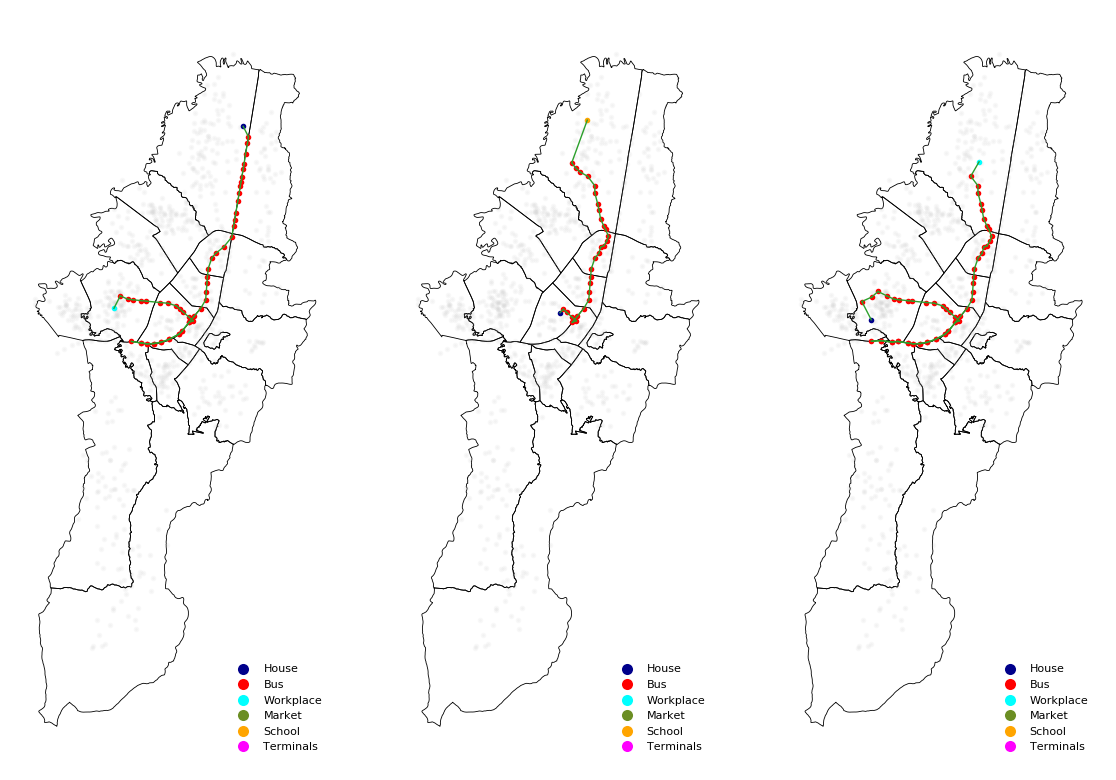

In [127]:
myDPI = 200
fig, ax = plt.subplots(1, 3, dpi=myDPI)#figsize=( 732.634438/myDPI,  837.435634/myDPI), dpi=myDPI)


pType = plotData['type'].value_counts().keys()

def color(x):
    if x == 'H':
        return 'darkblue'
    elif x == 'S':
        return 'orange'
    elif x == 'M':
        return 'oliveDrab'
    elif x == 'W':
        return 'cyan'
    elif x == 'T':
        return 'magenta'
    else:
        return 'red'
    

random_individual = [np.random.randint(1000) for i in range(3)]
#toPlotIndividuals = [230, 19, 55, 822, 790, 5, 15, 999, 82, 564]
toPlotIndividuals = random.sample(random_individual, 3)# [55, 5, 999, ]

for index, random_individual in enumerate(toPlotIndividuals):
    
    mapLocalidades.plot(ax = ax[index], edgecolor='black', facecolor='none', lw=0.3)

    # print(dataPeople.iloc[random_individual])
    
    routes = dataPeople.iloc[random_individual]['route']
    routes = list(map(int, routes.split(',')))

    for i in range(len(routes)-1):
        place1 = plotData[plotData['id'] == routes[i]]
        place2 = plotData[plotData['id'] == routes[i+1]]


        ax[index].plot([place1['x'].values[0], place2['x'].values[0]], 
                [place1['y'].values[0], place2['y'].values[0]],  
                c='C2', lw=0.5)


    ax[index].scatter(plotData['x'], plotData['y'], 
                   s=1, c='silver', alpha=0.1)



    for i in routes:
        place = plotData[plotData['id'] == i]
        ax[index].scatter(place['x'], place['y'], 
                   s=1, c=color(place['type'].values[0]))


    from matplotlib.lines import Line2D


    legend_elements = [Line2D([0], [0], marker='o', color='w', label='House',
                              markerfacecolor='darkblue', markersize=5),
                      Line2D([0], [0], marker='o', color='w', label='Bus',
                              markerfacecolor='red', markersize=5),
                      Line2D([0], [0], marker='o', color='w', label='Workplace',
                              markerfacecolor='cyan', markersize=5),
                      Line2D([0], [0], marker='o', color='w', label='Market',
                              markerfacecolor='oliveDrab', markersize=5),
                      Line2D([0], [0], marker='o', color='w', label='School',
                              markerfacecolor='orange', markersize=5),
                      Line2D([0], [0], marker='o', color='w', label='Terminals',
                              markerfacecolor='magenta', markersize=5),]


    ax[index].axis('off')
    ax[index].legend(handles = legend_elements, prop={'size': 4}, fontsize=6, loc=4, borderpad=0.2, frameon=False)

fig.tight_layout()    